All the imports

# New section

In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchsummary import summary
import torch.nn.functional as F
from torch import nn
from torchvision.transforms import Compose, Resize, ToTensor
import torchvision
import numpy as np
from tqdm import tqdm
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import pandas as pd
import os
import time

This is used to establish connection to the google drive, we are storing the data on google drive and extracting the zipped folder and storing the saved back on the drive

In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


This is used to extract zipped data folder

In [ ]:
import shutil  # package used to extract data

shutil.unpack_archive("/content/drive/MyDrive/rvl-cdip.tar.gz", "/data")

Data preprocessing of training and cross-validation data

In [ ]:
# Read and process the training data labels
train_p = open("/data/labels/train.txt").readlines()
train = []  # List to store training image paths
y_train = []  # List to store corresponding training labels
for path in train_p:
    pth = path.split("\n")  # split the line to get the image path and label
    pth, l = pth[0].split(" ")  # split the path and label
    y_train.append(int(l))  # convert label to integer and add to y_train
    p = "/data/images/" + pth  # Construct the full image path
    train.append(p)  # add image path to the train list

print(train_p[:10])
print(train[:10])

# Read and process the cv(cross-validation) data labels
cv_p = open(
    "/data/labels/val.txt"
).readlines()  # split the line to get the image path and label
cv = []  # list to store cv image paths
y_cv = []  # list to store corresponding cv labels
for path in cv_p:
    pth = path.split("\n")  # split the line to get the image path and label
    pth, l = pth[0].split(" ")  # split the path and label
    p = "/data/images/" + pth  # Construct the full image path

    cv.append(p)  # Add image path to the cv list
    y_cv.append(int(l))  # Convert label to integer and add to y_cv

['imagesq/q/o/c/qoc54c00/80035521.tif 15\n', 'imagese/e/w/c/ewc23d00/513280028.tif 1\n', 'imagesw/w/b/t/wbt26e00/2053453161.tif 7\n', 'imagesm/m/k/m/mkm05e00/2040792992_2040792994.tif 10\n', 'imageso/o/e/x/oex80d00/522787731+-7732.tif 3\n', 'imagesq/q/v/t/qvt06d00/50525666-5667.tif 14\n', 'imagesr/r/l/z/rlz20d00/521107137+-7140.tif 11\n', 'imagesk/k/n/i/kni98c00/87538356_8359.tif 13\n', 'imagesm/m/q/v/mqv03f00/0011846871.tif 0\n', 'imagesf/f/o/x/fox75a00/2505168109_8112.tif 2\n']
['/data/images/imagesq/q/o/c/qoc54c00/80035521.tif', '/data/images/imagese/e/w/c/ewc23d00/513280028.tif', '/data/images/imagesw/w/b/t/wbt26e00/2053453161.tif', '/data/images/imagesm/m/k/m/mkm05e00/2040792992_2040792994.tif', '/data/images/imageso/o/e/x/oex80d00/522787731+-7732.tif', '/data/images/imagesq/q/v/t/qvt06d00/50525666-5667.tif', '/data/images/imagesr/r/l/z/rlz20d00/521107137+-7140.tif', '/data/images/imagesk/k/n/i/kni98c00/87538356_8359.tif', '/data/images/imagesm/m/q/v/mqv03f00/0011846871.tif', '/da

Visualizing the data

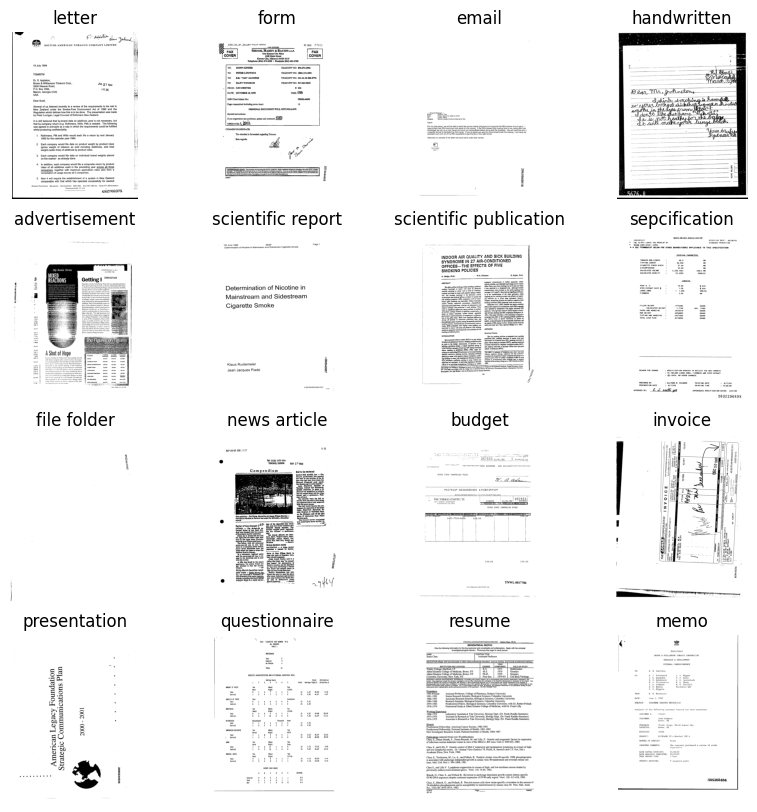

In [ ]:
import cv2
import os

# The class number along with the corresponding labels
class_dict = {
    0: "letter",
    1: "form",
    2: "email",
    3: "handwritten",
    4: "advertisement",
    5: "scientific report",
    6: "scientific publication",
    7: "sepcification",
    8: "file folder",
    9: "news article",
    10: "budget",
    11: "invoice",
    12: "presentation",
    13: "questionnaire",
    14: "resume",
    15: "memo",
}
# Visualizing the data
index = 0
i = 0
num_classes = 16  # the number of classes
images_lst = []  # list to store the images
labels_lst = []  # list to store the labels
while index < num_classes:  # loop to iterate and print one image per each class
    # take from train data
    label = int(train_p[i].split("\n")[0].split(" ")[-1])  # reading the label
    if index == label:
        index += 1
        images_lst.append(train[i])
        labels_lst.append(y_train[i])
        i += 1
    else:
        i += 1
        continue

fig, axes = plt.subplots(
    4, 4, figsize=(10, 10)
)  # creating subplots of all plots for the classes
row = 0
col = 0
for i in range(16):
    im = cv2.imread(images_lst[i], cv2.IMREAD_GRAYSCALE)
    axes[row][col].imshow(im, cmap="gray")
    axes[row][col].set_title(class_dict[i])
    axes[row][col].axis("off")
    col += 1
    if col % 4 == 0:
        col = 0
        row += 1

Storing the data into Dataframes of image paths and labels as columns

<Axes: >

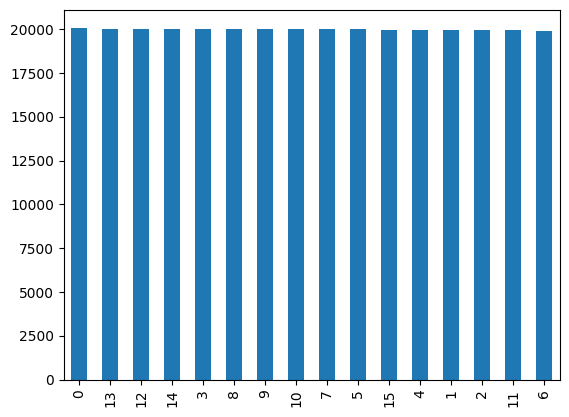

In [ ]:
# store them as dataframe, the image path and the labels
# used to see the total count for each class using bar plots
df_train = pd.DataFrame(list(zip(train, y_train)), columns=["paths", "labels"])
df_cv = pd.DataFrame(list(zip(cv, y_cv)), columns=["paths", "labels"])

# convert the labels values to integer
df_train.labels = df_train.labels.astype(int)
df_cv.labels = df_cv.labels.astype(int)

# visualizing the frequency of each class in the training dataset
df_train.labels.value_counts().plot(kind="bar")

Creating subfolders for each class and storing images for that particular class within them, used later with ImageFolder for generating DataLoader object

In [ ]:
# move the images to train folders
for i in range(0, 16):
    if not os.path.exists("/dataset/train/" + str(i)):
        os.makedirs("/dataset/train/" + str(i))
for i in range(0, 16):
    paths = list(df_train[df_train.labels == i].paths.values)[
        :10000
    ]  # using only 10,000 images per class, due to the storage and training constraint
    for path in paths:
        try:
            shutil.move(path, "/dataset/train/" + str(i))
        except:
            pass

# move the images to cv folders
for i in range(0, 16):
    if not os.path.exists("/dataset/cv/" + str(i)):
        os.makedirs("/dataset/cv/" + str(i))
for i in range(0, 16):
    paths = list(df_cv[df_cv.labels == i].paths.values)
    for path in paths:
        try:
            shutil.move(path, "/dataset/cv/" + str(i))
        except:
            pass

Transformation that is applied to the image

In [ ]:
# Define a sequence of transformation to be applied to an image
transform_t = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5],  # Normalize the tensor by subtracting mean values
            std=[
                0.5,
                0.5,
                0.5,
            ],  # Normalize the tensor by dividing by standard deviation values
        ),
    ]
)

Creating dataset and DataLoader objects of training and validation data

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(
    root="/dataset/train/", transform=transform_t
)  # Create a training dataset using the ImageFolder class from torchvision
cv_dataset = torchvision.datasets.ImageFolder(
    root="/dataset/cv/", transform=transform_t
)  # Create a cross-validation dataset using the ImageFolder class from torchvision

train_data_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=False
)
cv_data_loader = DataLoader(
    cv_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=False
)

Installing Timm package

In [ ]:
!pip install timm     # install timm module to import pretrained ViT models
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.6 MB/s eta 0:00:00


Setting GPU/CPU for training

In [ ]:
# Check if CUDA (GPU) is available and set the device accordingly
if torch.cuda.is_available():
    print("Training on GPU")
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

Training on GPU


Loading pretrained models

In [ ]:
model = timm.create_model(
    "vit_base_patch16_224.augreg2_in21k_ft_in1k", pretrained=True, num_classes=16
).to(
    device
)  # loads the pretrained ViT data that is trained on ImageNet-21k and fine tuned on ImageNet-1k
# to print the architecture of the model
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,771,776
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
           Linear-11             [-1, 197, 768]         590,592
          Dropout-12             [-1, 197, 768]               0
        Attention-13             [-1, 197, 768]               0
         Identity-14             [-1, 1

Training function

In [ ]:
# funtion to train the model, takes in model,train_data_loader,optimizer and the loss function
def train(model, trainloader, optimizer, criterion):
    # set the model to train mode
    model.train()
    print("Training")
    # Initialize the variables to track loss and accuracy
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data  # iterating over the dataloader
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()  # resetting all the gradients
        outputs = model(image)  # forward pass

        loss = criterion(outputs, labels)  # calculating the loss
        train_running_loss += loss.item()  # keeping track of the loss

        _, preds = torch.max(outputs.data, 1)  # predicted class
        train_running_correct += (
            (preds == labels).sum().item()
        )  # calculate the accuracy

        loss.backward()  # backpropagation
        optimizer.step()  # update the optimizer parameters

    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100.0 * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

Validation function

In [ ]:
def validate(model, testloader, criterion):
    model.eval()
    print("Validation")
    valid_running_loss = 0.0
    valid_running_correct = 0
    count = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            count += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / count
    epoch_acc = 100.0 * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

Saving the model

In [ ]:
# function to save the model
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save(
        {
            "epoch": epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
        },
        "/content/drive/MyDrive/model_DOC_VIT_{}.pth".format(epochs),
    )

**TRAINING**

In [ ]:
train_loss, valid_loss = [], []  # Lists to store training and validation loss
train_acc, valid_acc = [], []  # Lists to store training and validation accuracy

optimizer = SGD(model.parameters(), lr=0.1)  # Initialize optimizer
criterion = nn.CrossEntropyLoss()  # loss function

stepLR = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=2, gamma=0.1
)  # Learning rate scheduler
epochs = 10  # number of epochs
# start the training
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")

    train_epoch_loss, train_epoch_acc = train(
        model, train_data_loader, optimizer, criterion  # call to train function
    )

    valid_epoch_loss, valid_epoch_acc = validate(
        model, cv_data_loader, criterion  # call to validation function
    )

    stepLR.step()  # Adjust learning rate using the scheduler

    train_loss.append(train_epoch_loss)  # Append loss and accuracy values to lists
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    # Print training and validation metrics
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(
        f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}"
    )
    print("-" * 50)

    time.sleep(5)

    save_model(epoch, model, optimizer, criterion)  # Save model after each epoch


save_model(
    epoch + 1, model, optimizer, criterion
)  # Save the trained model weights after all epochs

print("Training is done")  # Print completion